In [1]:
# Imports
import torch
import os 
import sys
from dask_jobqueue import SLURMCluster
from distributed import Client
from pathlib import Path

import do_simulation_dr_discrete as file

In [2]:
# Args setup
ntrial = 100
n = 100
n_int = 2

In [3]:
# Cluster creation
cluster = SLURMCluster(
    n_workers=0,
    memory="16GB",
    processes=1,
    cores=1,
    scheduler_options={
        "dashboard_address": ":11111",
        "allowed_failures": 10
    },
    job_cpu=1,
    walltime="3:0:0",
    
    job_extra_directives = ["-p medium,fast,cpu"],
)
cluster.adapt(minimum=0, maximum=200)
client = Client(cluster)

In [4]:
# Submitting jobs
futures = []
for seed in range(ntrial):
        f = client.submit(file.main,
                              seed,
                              n,n_int,
                              )
        futures += [f]

In [5]:
futures

[<Future: pending, key: main-516479441a45ff1114baee7fd38cc744>,
 <Future: pending, key: main-ee295ff080f5fc3cf6733a6e6d3d9551>,
 <Future: pending, key: main-183b7000d5fbcc43165282be55f7d2a7>,
 <Future: pending, key: main-f567b6d1408894e1b139c69689004d2c>,
 <Future: pending, key: main-5eae22e81aadb2019fc401289c62110c>,
 <Future: pending, key: main-c3d5406d1fe65355fc22bf2c60215017>,
 <Future: pending, key: main-b804a61552e73ed2119a660b8cee2fe2>,
 <Future: pending, key: main-957f0fd3ead7d15cb71654483dc1b26e>,
 <Future: pending, key: main-17d875f547bf465d5aa77072d3c6edd1>,
 <Future: pending, key: main-af1edd7e53c6071d8bb865770d031077>,
 <Future: pending, key: main-2fe757f12d478287d2faeb7d2e226f48>,
 <Future: pending, key: main-ac14cee6f3546c778d86d5792b7a5adc>,
 <Future: pending, key: main-da57b32e701fcd475bd048e2f66912bd>,
 <Future: pending, key: main-62d3fc45cc266d5e3143c27dd28e225e>,
 <Future: pending, key: main-b334d18528a9a7ce2fe5e3a67d2293c3>,
 <Future: pending, key: main-6632e61366f

In [6]:
# Getting results
results = client.gather(futures)

In [7]:
# Closing client
client.close()
cluster.close()

In [8]:
mean = torch.zeros(ntrial)
se = torch.zeros(ntrial)
fracs = torch.zeros((ntrial,101))
for i in range(ntrial):
    mean[i] = results[i]['post_moments'][0]
    se[i] =  results[i]['post_moments'][1]**0.5
    fracs[i] =  results[i]['post_levels']
((0 <= (mean + 1.965*se) ) * (0 >= (mean - 1.965*se))).float().mean()

tensor(0.9600)

In [14]:
fracs.mean(0)[[80,90,95]]

tensor([0.8200, 0.9000, 0.9600])

In [16]:
mean.abs().mean(),mean.abs().std()

(tensor(0.3126), tensor(0.2412))

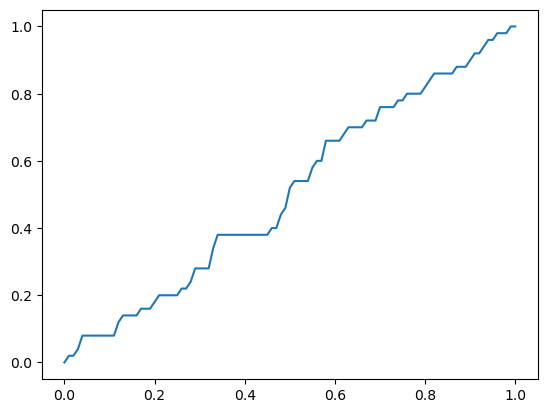

In [13]:
import matplotlib.pyplot as plt
import torch
plt.plot(torch.linspace(0,1,101),fracs.mean(0))

In [ ]:
import matplotlib.pyplot as plt
plt.hist(mean, bins = 20);

In [8]:
# Saving results
torch.save(obj = results,
           f = "simulation_dr_discrete_ntrial={0}_n={1}.pt".format(ntrial,n)
          )